# Importing Necessary Libraries

In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Creating The Model

In [7]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self,channels_img,features_d):
        super(Discriminator,self).__init__()
        self.disc = nn.Sequential(
            #Input: batch_size*channels_img*64*64
            nn.Conv2d(channels_img,features_d,kernel_size=4,stride=2,padding=1), #32*32
            nn.LeakyReLU(0.2),
            self.block(features_d,features_d*2,4,2,1), #16*16
            self.block(features_d*2,features_d*4,4,2,1), #8*8
            self.block(features_d*4,features_d*8,4,2,1), #4*4
            nn.Conv2d(features_d*8,1,kernel_size=4,stride=2,padding=0), #1*1
            nn.Sigmoid()
        )
    def block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),#we don't need bias as we are using batchnorm
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.disc(x)

#Generator
class Generator(nn.Module):
    def __init__(self,noise_dim,channels_img,features_g):
        super(Generator,self).__init__()
        self.gen = nn.Sequential(
            #Input: batch_size*noise_dim*1*1
            self.block(noise_dim,features_g*16,4,1,0), #batch_size*f_g*16*4*4
            self.block(features_g*16,features_g*8,4,2,1), #batch_size*f_g*8*8*8
            self.block(features_g*8,features_g*4,4,2,1), #batch_size*f_g*4*16*16
            self.block(features_g*4,features_g*2,4,2,1), #batch_size*f_g*2*32*32
            nn.ConvTranspose2d(features_g*2,channels_img,kernel_size=4,stride=2,padding=1),#batch_size*channel_img*64*64
            nn.Tanh()
        )
    def block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),#we don't need bias as we are using batchnorm
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self,x):
        return self.gen(x)


# Initializing The Model Weights As Per The Paper

In [8]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m,(nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data,0.0,0.02) #0 mean and .02 std

# Hyperparameters

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 2e-4
noise_dim = 100
img_size = 64
batch_size = 128
num_epochs = 200
channels_img = 3
features_d = 64
features_g = 64

# Dataset Anime_faces

In [10]:
composed_transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * channels_img, std=[0.5] * channels_img)
    ]
)
# dataset = datasets.MNIST(root="dataset/",train=True,transform = composed_transforms, download=True)
dataset = datasets.ImageFolder(root="/kaggle/input/anime-faces/anime faces/anime faces",transform = composed_transforms)
dataloader = DataLoader(dataset,batch_size = batch_size,shuffle =True)

# Initialization

In [11]:
gen = Generator(noise_dim,channels_img,features_g).to(device)
disc = Discriminator(channels_img,features_d).to(device)
initialize_weights(gen)
initialize_weights(disc)
opt_gen = optim.Adam(gen.parameters(),lr = lr,betas = (0.5,0.999))
opt_disc= optim.Adam(disc.parameters(),lr = lr,betas = (0.5,0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(24,noise_dim,1,1).to(device)

# Train Loop

In [ ]:
# %%time
output_dir = "/kaggle/working/images"
# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
gen_loss = []
disc_loss = []
gen.train()
disc.train()
for epoch in range(num_epochs):
    total_lossD = 0.0
    total_lossG = 0.0
    
    # Create tqdm progress bar
    with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as t:
        for batch_idx, (real_img, label) in t:
            real_img = real_img.to(device)  
            noise = torch.randn(batch_size, noise_dim,1,1).to(device)
            fake_img = gen(noise)
        
            #Train Discriminator : loss = max (log(D(real)) + log(1-D(G(noise)))) === min(-(log(D(real)) + log(1-D(G(noise)))))
            disc_real = disc(real_img).view(-1) #to flatten from [32,1] to [32]
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake_img).view(-1)
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2
            opt_disc.zero_grad()
            lossD.backward(retain_graph=True)#to use the fake_img , otherwise it will be cleared out during back propagation
            opt_disc.step()
            
            #Train Generator: loss = min log(1-D(G(z))) --->gives us weak gradients,not so good for training -> max(log(D(G(z)))) === min(-log(D(G(z))))
            output = disc(fake_img).view(-1)
            lossG = criterion(output, torch.ones_like(output))
            opt_gen.zero_grad()
            lossG.backward()
            opt_gen.step()
            
            # Accumulate losses
            total_lossD += lossD.item()
            total_lossG += lossG.item()
            
            # Update tqdm description with current losses
            t.set_postfix({'D_loss': total_lossD / (batch_idx + 1), 'G_loss': total_lossG / (batch_idx + 1)})
        
    # Compute average losses for the epoch
    avg_lossD = total_lossD / len(dataloader)
    avg_lossG = total_lossG / len(dataloader)
    disc_loss.append(avg_lossD)
    gen_loss.append(avg_lossG)

    # Print discriminator and generator average losses for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Discriminator Loss: {avg_lossD:.4f}, Avg Generator Loss: {avg_lossG:.4f}")
    
    if epoch%5==0 or epoch==199:
        with torch.no_grad():
            fake_vid = gen(fixed_noise).reshape(-1,3,64,64)
            img_grid_fake_vid = torchvision.utils.make_grid(fake_vid,normalize=True)

            # Storing the fake images generated from fixed noise
            plt.figure(figsize=(10, 5))
            plt.imshow(torchvision.utils.make_grid(img_grid_fake_vid.cpu(), normalize=True).permute(1, 2, 0))
            plt.title(f"Fake Images From Fixed Noise (Epoch {epoch+1})")
            plt.axis('off')
            # Save the image
            plt.savefig(os.path.join(output_dir, f"epoch_{epoch+1}.png"))
        
            plt.show()

# Plotting Losses

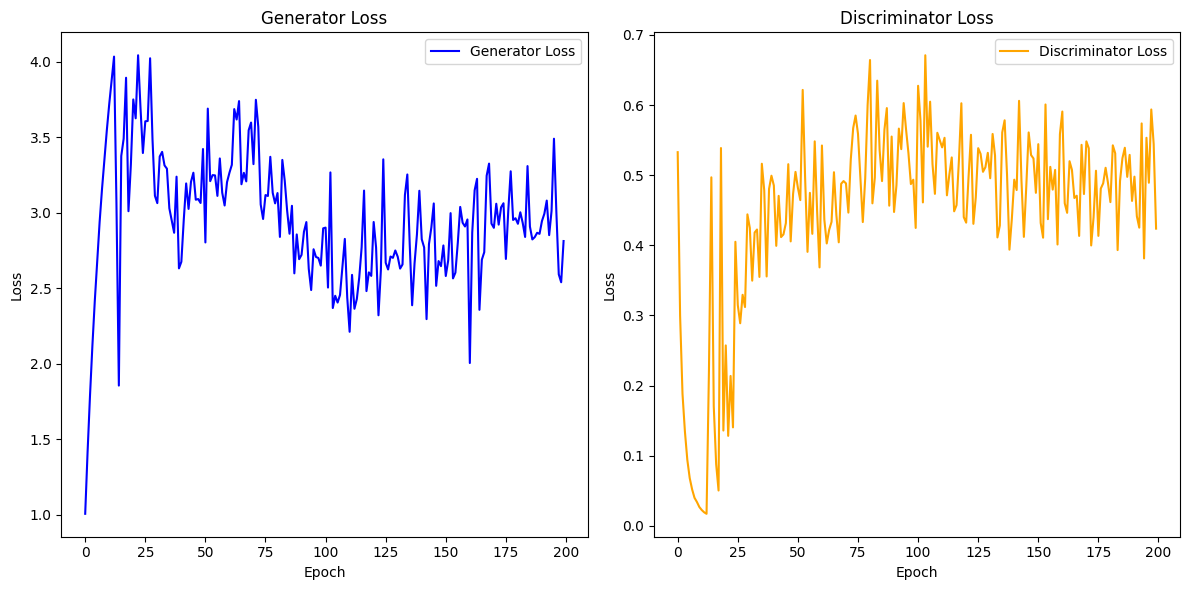

In [13]:
plt.figure(figsize=(12, 6))

# Plotting generator loss
plt.subplot(1, 2, 1)
plt.plot(gen_loss, label='Generator Loss', color='blue')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting discriminator loss
plt.subplot(1, 2, 2)
plt.plot(disc_loss, label='Discriminator Loss', color='orange')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Converting Generated Images from Fixed Noise to Video

In [16]:
# Convert images to video
import cv2
import glob

# Get the list of image files sorted
image_files = ['/kaggle/working/images/epoch_1.png','/kaggle/working/images/epoch_6.png','/kaggle/working/images/epoch_11.png','/kaggle/working/images/epoch_16.png',
 '/kaggle/working/images/epoch_21.png',
 '/kaggle/working/images/epoch_26.png',
 '/kaggle/working/images/epoch_31.png',
 '/kaggle/working/images/epoch_36.png',
 '/kaggle/working/images/epoch_41.png',
 '/kaggle/working/images/epoch_46.png',
 '/kaggle/working/images/epoch_51.png',
 '/kaggle/working/images/epoch_56.png',
'/kaggle/working/images/epoch_61.png',
 '/kaggle/working/images/epoch_66.png',
 '/kaggle/working/images/epoch_71.png',
 '/kaggle/working/images/epoch_76.png',
 '/kaggle/working/images/epoch_81.png',
 '/kaggle/working/images/epoch_86.png',
 '/kaggle/working/images/epoch_91.png',
 '/kaggle/working/images/epoch_96.png'
 '/kaggle/working/images/epoch_101.png',
 '/kaggle/working/images/epoch_106.png',
 
 '/kaggle/working/images/epoch_111.png',
 '/kaggle/working/images/epoch_116.png',
 '/kaggle/working/images/epoch_121.png',
 '/kaggle/working/images/epoch_126.png',
 '/kaggle/working/images/epoch_131.png',
 '/kaggle/working/images/epoch_136.png',
 '/kaggle/working/images/epoch_141.png',
 '/kaggle/working/images/epoch_146.png',
 '/kaggle/working/images/epoch_151.png',
 '/kaggle/working/images/epoch_156.png',
 
 '/kaggle/working/images/epoch_161.png',
 '/kaggle/working/images/epoch_166.png',
 '/kaggle/working/images/epoch_171.png',
 '/kaggle/working/images/epoch_176.png',
 '/kaggle/working/images/epoch_181.png',
 '/kaggle/working/images/epoch_186.png',
 '/kaggle/working/images/epoch_191.png',
 '/kaggle/working/images/epoch_196.png',
 '/kaggle/working/images/epoch_200.png',
]


frame = cv2.imread(image_files[0])
height, width, layers = frame.shape

video_name = 'generated_images.avi'
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 2, (width, height)) #2->fps

for image_file in image_files:
    video.write(cv2.imread(image_file))

video.release()

print(f"Video saved as {video_name}")

[ WARN:0@166.362] global loadsave.cpp:248 findDecoder imread_('/kaggle/working/images/epoch_96.png/kaggle/working/images/epoch_101.png'): can't open/read file: check file path/integrity


Video saved as generated_images.avi
